# Quantum Phase Estimation

In [1]:
from qiskit import QuantumCircuit
from qiskit.providers.basic_provider import BasicSimulator
from qiskit.visualization import plot_histogram, plot_bloch_vector, plot_bloch_multivector
from qiskit.primitives import BackendSampler
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from numpy import pi
import numpy as np
import matplotlib.pyplot as plt

## Objective

The quantum phase estimation algorithm (QPE) is very key for many quantum algorithms. It's goal is to find the eigenvalue of some given eigenstate of a unitary operator. In this problem we are given two things: a unitary operator $U$ and one of its eigenvalues $|\psi\rangle$. As we have previously discussed, because it is a unitary operator, we can write

$$U|\psi\rangle = e^{2\pi i\varphi}|\psi\rangle$$

where $0\leq\varphi<1$. Our goal is to estimate the eigenvalue and thus the phase $\varphi$ of $|\psi\rangle$. Just like with the Hadamard test, the phase of $U$ is written onto our control qubits. But because this is in the Fourier basis, we apply the inverse $\text{QFT}$ to transform it to the computational basis to perform a measurement. Recall from the $\text{QFT}$ section that in the Fourier basis the topmost qubit completes one rotation when counting from $0$ to $2^n$ where $n$ is the number of control qubits. For example, to count to some number $x$ between $0$ and $2^n$, the rotation of the first three qubits $R_{q_{n}}$ around the $z$-axis is as follows:

$$R_{q_0} = \frac{x}{2^n} \qquad R_{q_1} = \frac{2x}{2^n} \qquad R_{q_2} = \frac{4x}{2^n}$$

When performing a controlled-$U$ operation, as we mentioned before, the qubit will proportionally rotate to the phase $e^{2\pi i \varphi}$. In order to correctly encode the phase $\varphi$ (a number between $0$ and $2^n$), we can apply $C-U$ gates in succession to repeat this rotation a number of times until the phase $\varphi$ has been applied in the Fourier basis. Then by using the inverse $\text{QFT}$ we transform it to the computational basis for measurement.  

## Proof

Let's walk through the math of this procedure and how it is implemented as a circuit. We start with some state $|\psi\rangle$ as one set of qubit registers and $n$ counting qubits making up the counting register. Because all of our qubits start in the state $|0\rangle$, we can represent the initial state of our circuit as

$$|\psi_0\rangle = |0\rangle^{\otimes n}|\psi\rangle$$

To put each counting qubit into superposition we then apply a Hadamard gate to all $n$ qubits putting our circuit in the state

$$|\psi_1\rangle = \frac{1}{\sqrt{2^n}}(|0\rangle + |1\rangle)^{\otimes n}|\psi\rangle$$

We then apply our $C-U$ gates. Since we already know that $U|\psi\rangle = e^{2\pi i\varphi}|\psi\rangle$, when applying this gate to all $n$ qubits, it then follows that 

$$U^{2^j}|\psi\rangle = U^{2^{j}-1}U|\psi\rangle = U^{2^{j}-1}e^{2\pi i \varphi}|\psi\rangle = U^{2^{j}-2}e^{4\pi i \varphi}|\psi\rangle = \dots = e^{2\pi i 2^j \varphi}|\psi\rangle$$

Therefore, by controlling this gate and applying it to all $n$ qubits, we must apply $C-U^{2^j}$ where $0 \leq j \leq n-1$. This leaves us with

$$|\psi_2\rangle = \frac{1}{\sqrt{2^n}}\left(|0\rangle + e^{2\pi i \varphi 2^{n-1}}|1\rangle\right)\otimes \left(|0\rangle + e^{2\pi i \varphi 2^{n-2}}|1\rangle\right) \otimes \dots \otimes \left(|0\rangle + e^{2\pi i \varphi 2^{0}}|1\rangle\right)\otimes|\psi\rangle= \frac{1}{\sqrt{2^n}} \sum_{k=0}^{2^n-1}e^{2\pi i \varphi k}|k\rangle\otimes|\psi\rangle$$

Here, $k$ is the integer representation of $n$-bit binary numbers.

show that we can measure phase using inverse qft (similar process to proving qft)

## Verification

In [2]:
def add_inv_fourier_transform(circuit, qubits, show_steps = False):
    circuit.barrier()
    for i in range(int(qubits/2)):
        circuit.swap(i, qubits-i-1)
    for highest in range(qubits):
        if show_steps: print("\nPreforming inverse transform on qubit", highest)
        circuit.barrier()
        for qubit in range(highest):
            # qubit = highest-j-1
            if show_steps: print("\tControl Phase -π/2^"+str(highest-qubit)+" gate applied to", highest, "using qubit", qubit, "as control")
            circuit.cp(-pi/2**(highest-qubit), highest, qubit)
        if show_steps: print("\tAdding H gate to qubit", highest)
        circuit.h(highest) 
    if show_steps: print("\nCompleted transformation\n")

def setup(circuit, ancilla_bits):
    for i in range(ancilla_bits):
        circuit.h(i)

def measure(circuit, ancilla_bits):
    for i in range(ancilla_bits):
        qc.measure(i,i)

In [23]:
ancilla_bits = 3

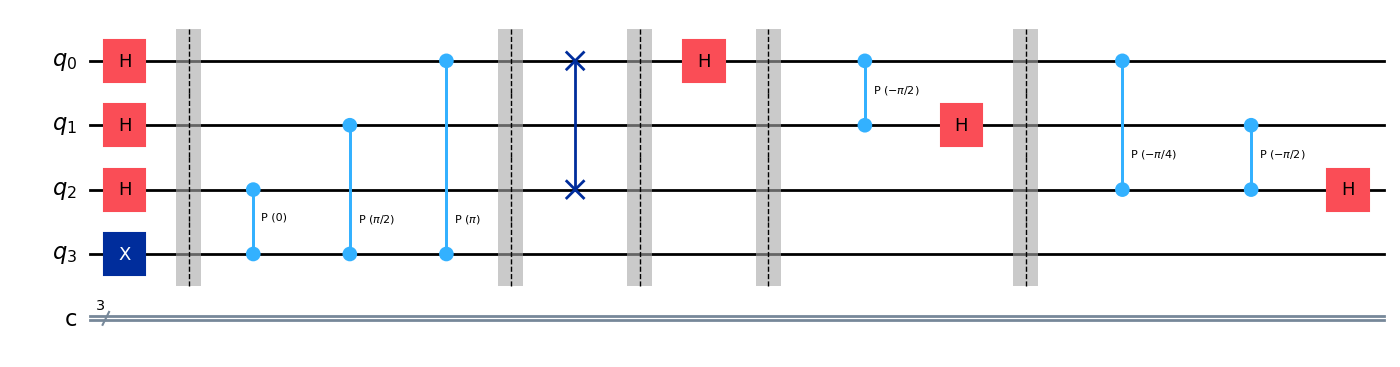

In [24]:
qc = QuantumCircuit(ancilla_bits+1, ancilla_bits)
setup(qc, ancilla_bits)
qc.x(ancilla_bits)
qc.barrier()
for i in range(ancilla_bits):
    qc.cp(pi/2*i, ancilla_bits,ancilla_bits-i-1)

add_inv_fourier_transform(qc,ancilla_bits)
qc.draw('mpl')

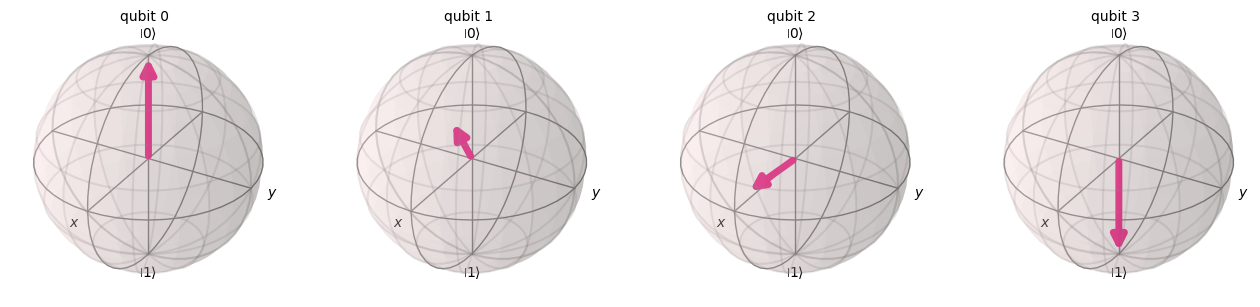

In [25]:
sv = Statevector(qc)
plot_bloch_multivector(sv)

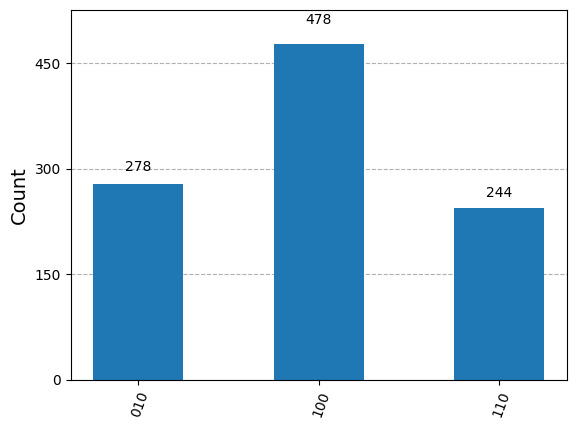

In [26]:
measure(qc, ancilla_bits)
result = BasicSimulator().run(qc, shots=1000).result()   
counts = result.get_counts()                    
plot_histogram(counts)

In [27]:
binary_num = max(result.get_counts())
decimal_num = 0
for i in range(len(binary_num)):
    decimal_num += int(binary_num[i])/2**(ancilla_bits-i)
print(decimal_num)

0.375
